In [1]:
# !pip install pandas_datareader
# !pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas_datareader as pdr
import yfinance as yf

2023-10-21 10:31:00.168727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-21 10:31:00.168799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-21 10:31:00.168822: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-21 10:31:00.178254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = yf.download("AAPL", start="2013-10-16", end="2023-10-16").reset_index()
print("Data Shape after load: ", data.shape)

[*********************100%%**********************]  1 of 1 completed
Data Shape after load:  (2516, 7)


In [4]:
import sklearn.preprocessing as preprocessing

# data cleaning
data = data.ffill()
data = data.drop(['Date'], axis=1)
#check na
if data.isna().sum().sum() != 0:
    print("There are still NA values")
    data = data.bfill()

print("Data Shape after cleaning: ", data.shape)

cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# perform scaling
scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(data[cols])
    
print("Data Shape after removing outliers: ", data.shape)

Data Shape after cleaning:  (2516, 6)
Data Shape after removing outliers:  (2516, 6)


In [5]:
numberOfInputDays = 7
numberOfDaysToPredict = 1

# create sequence
def create_sequence(data, numberOfInputDays, numberOfDaysToPredict):
    x = []
    y = []
    # for i in range(numberOfInputDays, data.shape[0] - numberOfDaysToPredict + 1):
    #     x.append(data.iloc[i-numberOfInputDays:i, 1:len(cols)+1])
    #     y.append(data.iloc[i:i+numberOfDaysToPredict][cols])
    # return np.array(x), np.array(y)
     
    for i in range(len(data)-numberOfInputDays):
        x.append(data[i:i+numberOfInputDays])
        y.append(data[i+numberOfInputDays])
    return np.array(x), np.array(y)
    
X, Y = create_sequence(data, numberOfInputDays, numberOfDaysToPredict)

print("X Shape: ", X.shape)
print("Y Shape ", Y.shape)

X Shape:  (2509, 7, 6)
Y Shape  (2509, 6)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.2)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print("X_train Shape: ", X_train.shape)
print("Y_train Shape: ", Y_train.shape)
print("X_test Shape: ", X_test.shape)
print("Y_test Shape: ", Y_test.shape)


X_train Shape:  (2007, 7, 6)
Y_train Shape:  (2007, 6)
X_test Shape:  (502, 7, 6)
Y_test Shape:  (502, 6)


In [7]:
# apply RNN
def defineModel(numberOfInputDays,units):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=units, input_shape=(numberOfInputDays, len(cols))))
    model.add(keras.layers.Dense(units=len(cols), activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [8]:
def fitModelToHyperparameter(X_train, Y_train,numberOfInputDays, units, epochs, batchSize):
    model = defineModel(numberOfInputDays, units)
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batchSize, validation_split=0.1)
    return model, history

def gridSearch(units, epochs, batchSizes):
    bestMSE = float('inf')
    bestPrarams = None
    bestModel = None
    bestHistory = None
    numberOfIters = len(units) * len(epochs) * len(batchSizes)
    currentIter = 1
    for unit in units:
        for epoch in epochs:
            for batchSize in batchSizes:
                print(f"Case : {currentIter}/{numberOfIters}")
                print("Unit: ", unit, "Epoch: ", epoch, "Batch Size: ", batchSize)
                fittedModel,fittedHistory = fitModelToHyperparameter(X_train, Y_train, numberOfInputDays, unit, epoch, batchSize)
                current_y_pred = fittedModel.predict(X_test)
                current_y_pred = scaler.inverse_transform(current_y_pred)
                y_actual = scaler.inverse_transform(Y_test.reshape(-1, len(cols)))
                mean_squared_error = metrics.mean_squared_error(y_actual, current_y_pred)
                currentIter += 1
                
                if mean_squared_error < bestMSE:
                    bestMSE = mean_squared_error
                    bestPrarams = {'units': unit, 'epochs': epoch, 'batch_size': batchSize}
                    bestModel = fittedModel
                    bestHistory = fittedHistory
    print("Best MSE: ", bestMSE)
    print("Best Params: ", bestPrarams)
    return bestModel, bestHistory


In [9]:
bestModel,bestHistory = gridSearch([32, 64, 128], [10, 20, 30], [16, 32, 64])

Case : 1/27
Unit:  32 Epoch:  10 Batch Size:  16


2023-10-21 10:31:03.392777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 10:31:03.397562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 10:31:03.397624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 10:31:03.401736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 10:31:03.401812: I tensorflow/compile

Epoch 1/10


2023-10-21 10:31:07.352055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-21 10:31:08.108633: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6848208c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-21 10:31:08.108697: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-10-21 10:31:08.132397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  6/113 [>.............................] - ETA: 1s - loss: 0.0190  

2023-10-21 10:31:08.353086: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 [==============================] - 5s 14ms/step - loss: 0.0108 - val_loss: 0.0731
Epoch 2/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0074 - val_loss: 0.0725
Epoch 3/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0728
Epoch 4/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0725
Epoch 5/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0729
Epoch 6/10
113/113 [==============================] - 1s 8ms/step - loss: 0.0073 - val_loss: 0.0732
Epoch 7/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0727
Epoch 8/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0729
Epoch 9/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0727
Epoch 10/10
16/16 [==============================] - 0s 4ms/step
Case : 2/27
Unit:  32 Epoch:  10 Batch Size: 

In [10]:
# def trainModel(model, X_train, Y_train,epochs=50, batch_size=32):
#     with tf.device('/device:GPU:0'):
#         train_history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, shuffle=False)
#     return train_history

In [11]:
# train_history = trainModel(model, X_train, Y_train,epochs=20, batch_size=32)

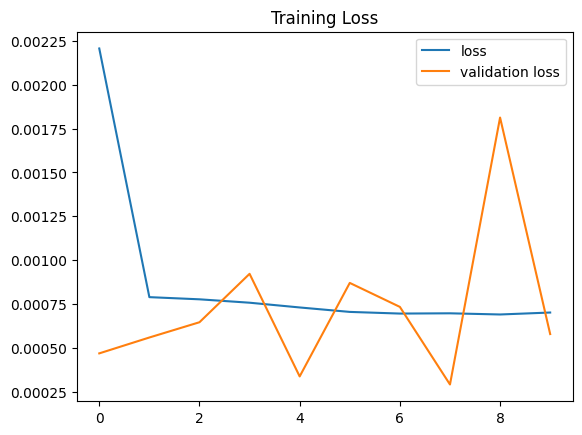

In [12]:
# print history data
plt.plot(bestHistory.history['loss'], label='loss')
plt.plot(bestHistory.history['val_loss'], label='validation loss')
plt.legend()
plt.title("Training Loss")
plt.show()

In [13]:
# Total Mean Squared Error for test
mse = bestModel.evaluate(X_test, Y_test)
print("MSE on test: ", mse)

10/16 [=================>............] - ETA: 0s - loss: 0.0012

16/16 [==============================] - 0s 6ms/step - loss: 0.0014
MSE on test:  0.0014496376970782876


In [14]:
def predict(model, data):
    with tf.device('/device:GPU:0'):
        last_n_days = data[-numberOfInputDays:]
        last_n_days = last_n_days.reshape((1, numberOfInputDays, len(cols)))
        prediction = model.predict(last_n_days)
        real_predicted_price = scaler.inverse_transform(prediction)
    return real_predicted_price

In [15]:
predicted_price = predict(bestModel, data)

1/1 [==============================] - 0s 22ms/step


In [16]:
print("Predicted Price: ", predicted_price)

Predicted Price:  [[1.7022781e+02 1.7707683e+02 1.7059752e+02 1.7055446e+02 1.6848038e+02
  6.7182720e+07]]


In [17]:
#save model
bestModel.save('task2.keras')

In [18]:
# # data to use for testing flask 
# import yfinance as yf
# data = yf.download("AAPL", start="2021-10-20", end="2021-10-29").reset_index()
# data
# # date = "2021-10-10"
# # date = pd.to_datetime(date)
# # date
# # save as csv 
# data.to_csv('task2.csv', index=False)

In [19]:
# date = date+pd.DateOffset(days=1)
# date